# Projeto de otimização de portfólio
##### *Autor*: Victor Flávio P. Dornelos

## 1 Análise exploratória dos dados

In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import yfinance as yf
import pickle
from help import alocacao_ativos, visualiza_carteira,alocacao_markowitz

In [2]:
# Lista com as ações da carteira
acoes = ['TAEE11.SA','BBAS3.SA','ABEV3.SA','WEGE3.SA','RANI3.SA','GOGL34.SA','BERK34.SA']

In [3]:
# Criando DF com as cotações usando Adj Close pelo yfinance
#df = pd.DataFrame()
#for i in acoes:
    #df[i] = yf.download(i, start='2021-01-01')['Adj Close']

In [4]:
# Salvando DF para evitar possíveis com yfinance
#df.to_csv('carteira.csv')
df=pd.read_csv('carteira.csv',index_col='Date')

In [5]:
# Descrição estatística dos dados
df.describe()

,TAEE11.SA,BBAS3.SA,ABEV3.SA,WEGE3.SA,RANI3.SA,GOGL34.SA,BERK34.SA
count,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000
mean,31.626524,18.246046,13.520553,34.422752,7.095992,53.073726,81.337269
std,3.194593,5.448385,0.946959,4.205932,1.941754,8.912342,9.680268
min,21.692646,11.193897,11.520000,22.032598,3.993166,35.822094,59.950001
25%,29.438837,13.516212,12.857918,32.057381,5.521672,46.702682,74.842497
50%,32.228571,16.189788,13.493954,34.935814,6.871072,52.069439,80.119999
75%,34.095095,22.951791,14.006313,37.730060,8.648023,58.549703,85.727503
max,36.577717,29.474905,17.029501,43.637676,12.309293,77.540001,109.150002


/var/folders/f0/r1mlkllj4z14dx7__963964m0000gn/T/ipykernel_4229/1035196785.py:4: UserWarning: The palette list has more values (13) than needed (7), which may not be intended.
  sns.boxplot(data=df,palette=cores)


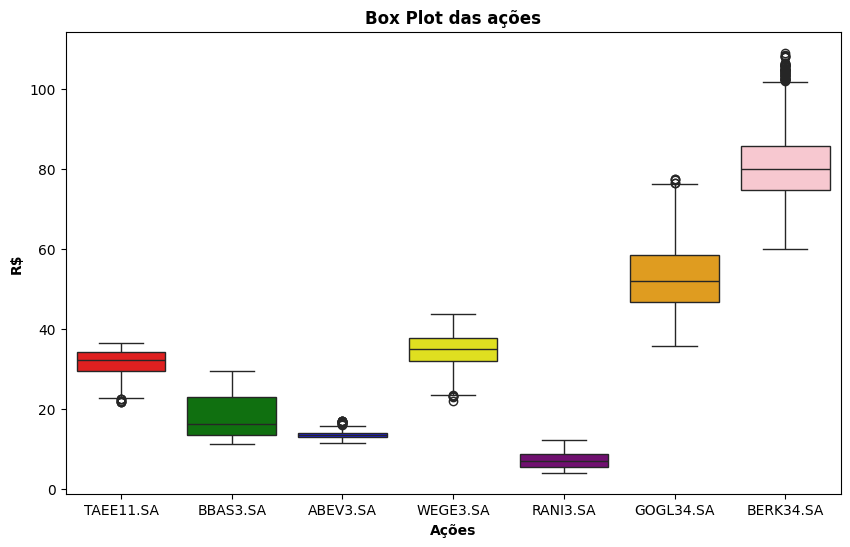

In [6]:
# Criando Box Plot para os papéis
cores= ["Red", "Green", "Blue", "Yellow", "Purple", "Orange", "Pink", "Brown", "Black", "White", "Gray", "Cyan", "Magenta"]
plt.figure(figsize=(10, 6))
sns.boxplot(data=df,palette=cores)
plt.title('Box Plot das ações',fontweight='bold')
plt.xlabel('Ações',fontweight='bold')
plt.ylabel('R$',fontweight='bold')
plt.grid(False)
plt.show()

Durante o intervalo de tempo de 2021 até Junho de 2024, o gráfico Box Plot e a descrição do df, destacam que a Irani e Ambev tiveram uma baixa dispersão, enquanto, a Google e a Berkshire Hathaway tiveram uma grande volatilidade comparada as demais.

In [7]:
# Criando gráfico das cotações
figura = px.line(title = 'Histórico de cotações das ações')

for i, coluna in enumerate(df.columns):
    figura.add_scatter(x=df.index, y=df[coluna], name=coluna, line=dict(color=cores[i]))


figura.update_layout(
    xaxis_title='Data',
    yaxis_title='R$',
    title_x=0.5
)

figura.show()

In [8]:
# Normalizando as cotações para melhor comparação dos retornos
df_normalizado = df.copy()
for i in df_normalizado.columns[0:]:
  df_normalizado[i] = df_normalizado[i] / df_normalizado[i][0];

/var/folders/f0/r1mlkllj4z14dx7__963964m0000gn/T/ipykernel_4229/1711867627.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [9]:
# Criando gráfico das cotações normalizadas
figura = px.line(title = 'Histórico de cotações das ações (normalizado)')

for i, coluna in enumerate(df.columns):
    figura.add_scatter(x=df_normalizado.index, y=df_normalizado[coluna], name=coluna, line=dict(color=cores[i]))


figura.update_layout(
    xaxis_title='Data',
    yaxis_title='R$',
    title_x=0.5
)

figura.show()

A empresa com melhor resultado é a Irani, apresentando uma rentabilidade muito próxima à da Google. Banco do Brasil e Berkshire Hathaway tiveram desempenhos semelhantes, ambos inferiores aos da Irani e Google. Taesa também registrou resultados inferiores, mas Weg e Ambev destacaram-se pelo pior desempenho.

## 2 Otimização de portfólio

### 2.1 Preparação

In [10]:
# Biblioteca necessária
#pip install https://github.com/gkhayes/mlrose/archive/refs/heads/master.zip

In [11]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

In [12]:
# Biblioteca para buscar valores de CDI
#pip install python-bcb

from bcb import sgs

In [13]:
#taxa_cdi = sgs.get({'cdi':4389},start='2021-01-01')
#media_cdi = float(taxa_cdi.mean() / 100)
media_cdi = 0.10140104772991852 # Salvando valor devido instabilidade do BCB

In [14]:
# Pegando DF limpo
teste = pd.read_csv('carteira.csv')

### 2.2 Método  Markowitz

In [15]:
# Rodando a função
import warnings
warnings.filterwarnings("ignore")
#melhor_sharpe_ratio, pesos_markoitz, lista_retorno_esperado, lista_volatilidade_esperada, lista_sharpe_ratio, melhor_volatilidade, melhor_retorno = alocacao_markowitz(teste, 100000, media_cdi, 100000);

In [16]:
# Criando uma carteira com os pesos encontrados
#df_M,_,_,_=alocacao_ativos(teste,capital=100000,melhores_pesos=pesos_markoitz)
df_M = pd.read_csv('df_M.csv')

In [17]:
# Devido esse código demorar muito, torna interessante salvar os resultados
#dados_M = {
    #"melhor_sharpe_ratio": melhor_sharpe_ratio,
    #"pesos_markoitz": pesos_markoitz,
    #"lista_retorno_esperado": lista_retorno_esperado,
   # "lista_volatilidade_esperada": lista_volatilidade_esperada,
   # "lista_sharpe_ratio": lista_sharpe_ratio,
   # "melhor_volatilidade": melhor_volatilidade,
    #"melhor_retorno": melhor_retorno}


In [18]:
#with open('dados_alocacao_markowitz.pkl', 'wb') as f:
    #pickle.dump(dados_M, f)

In [19]:
with open('dados_alocacao_markowitz.pkl', 'rb') as f:
    dados_M = pickle.load(f)

In [20]:
#df_M.to_csv('df_M.csv')

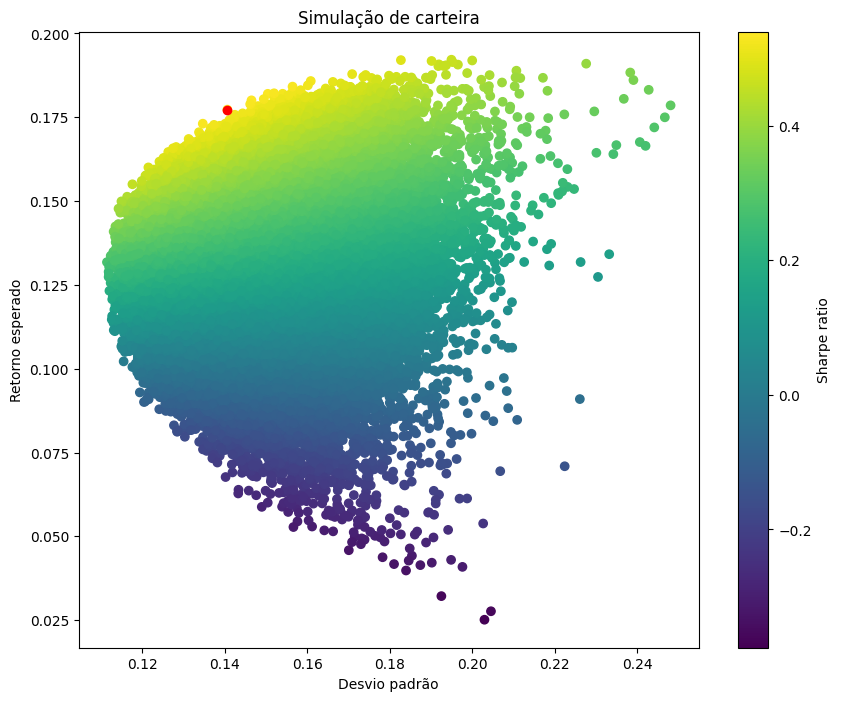

In [21]:
# Gráfico de dispersão
plt.figure(figsize=(10,8))
plt.scatter(dados_M["lista_volatilidade_esperada"], dados_M['lista_retorno_esperado'], c = dados_M['lista_sharpe_ratio'])
plt.colorbar(label = 'Sharpe ratio')
plt.title('Simulação de carteira')
plt.xlabel('Desvio padrão')
plt.ylabel('Retorno esperado')
plt.scatter(dados_M['melhor_volatilidade'], dados_M['melhor_retorno'], c = 'red');

# 2.3 Método Hill Climb

In [22]:
df = pd.read_csv('carteira.csv')

In [23]:
# Função para maximizar Shape ration
def fitness_function(pesos):
  df = pd.read_csv('carteira.csv')
  capital = 100

  for i in df.columns[1:]:
    df[i] = (df[i] / df[i][0])

  for i, k in enumerate(df.columns[1:]):
    df[k] = df[k] * pesos[i] * capital

  df.drop(labels = ['Date'], axis = 1, inplace=True)
  df['Capital'] = df.sum(axis = 1)
  df['tx retorno'] = 0.0

  for i in range(1, len(df)):
    df['tx retorno'][i] = ((df['Capital'][i] / df['Capital'][i - 1]) - 1) * 100

  sharpe_ratio = (df['tx retorno'].mean() - media_cdi) / df['tx retorno'].std() * np.sqrt(246)

  return sharpe_ratio

In [24]:
# Função para otimizar portfólio 
def Hill_climb():
    np.random.seed(10)
    pesos = np.random.random(len(df.columns) - 1)
    pesos = pesos / pesos.sum()
    fitness_function(pesos)
    fitness = mlrose.CustomFitness(fitness_function)
    maximizacao = mlrose.ContinuousOpt(length=len(teste.columns)-1, fitness_fn=fitness, maximize = True, min_val = 0, max_val = 1)
    pesos_HC, Sharpe_HC = mlrose.hill_climb(maximizacao, random_state = 1)
    pesos_HC = pesos_HC / pesos_HC.sum()
    return pesos_HC,Sharpe_HC

In [25]:
# Utilizando o método Hill Climb
#pesos_HC,sharpe_HC= Hill_climb()

In [26]:
# Devido esse código demorar muito, torna interessante salvar os resultados
    #dados_HC = {
    #"pesos_HC": pesos_HC,
    #"sharpe_HC": sharpe_HC,
#} 

In [27]:
#with open('dados_alocacao_hill_climb.pkl', 'wb') as f:
    #pickle.dump(dados_HC, f)

In [28]:
with open('dados_alocacao_hill_climb.pkl', 'rb') as f:
    dados_HC = pickle.load(f)

In [29]:
df_HC = pd.read_csv('df_hc.csv')

In [30]:
# Criando uma carteira para Hill Climb
#df_HC, _, _, soma_valor = alocacao_ativos(pd.read_csv('carteira.csv'), 100000, melhores_pesos=dados_HC['pesos_HC'])
#df_HC.to_csv('df_HC.csv') # Devido a demora de processamento é útil salvar os resultados

## 2.4 Método Simulated_annealing

In [31]:
# Função para otimizar portfólio 
def Simulated_annealing():
   np.random.seed(10)
   pesos = np.random.random(len(df.columns) - 1)
   pesos = pesos / pesos.sum()
   fitness_function(pesos)
   fitness = mlrose.CustomFitness(fitness_function)
   maximizacao = mlrose.ContinuousOpt(length=len(teste.columns)-1, fitness_fn=fitness, maximize = True, min_val = 0, max_val = 1)
   pesos_SA, Sharpe_SA = mlrose.simulated_annealing(maximizacao, random_state = 1)
   pesos_SA = pesos_SA/ pesos_SA.sum()
   return pesos_SA,Sharpe_SA


In [32]:
# Utilizando o método Simulated Annealing
#pesos_SA,sharpe_SA= Simulated_annealing()

In [33]:
# Devido esse código demorar muito, torna interessante salvar os resultados
#dados_SA = {"pesos_SA": pesos_SA, "shape_SA": sharpe_SA,}

In [34]:
#with open('dados_alocacao_simulated_annealing2.pkl', 'wb') as f:
    #pickle.dump(dados_SA, f)

In [35]:
with open('dados_alocacao_simulated_annealing.pkl', 'rb') as f:
    dados_SA = pickle.load(f)

In [36]:
# Observando o resultado
#df_SA, _, _, _ = alocacao_ativos(pd.read_csv('carteira.csv'), 100000, melhores_pesos=pesos_SA)
#df_SA.to_csv('df_SA.csv')

In [37]:
df_SA=pd.read_csv('df_SA.csv')

# 3 Comparativo dos resultados

### 3.1 Rentabilidade

In [38]:
# Buscando os dados do Bova 11
#df_bov = pd.DataFrame()
#df_bov['BOVA11']= yf.download('BOVA11.SA', start='2021-01-01',end='2024-06-04')['Adj Close']
#df_bov.to_csv('bova11.csv')

In [42]:
# Buscando os dados do IVVB 11
df_ivvb = pd.DataFrame()
df_ivvb['IVVB11'] = yf.download('IVVB11.SA', start='2021-01-01', end='2024-06-04')['Adj Close']
df_ivvb.to_csv('ivvb11.csv')

[*********************100%%**********************]  1 of 1 completed


In [43]:
df_ivvb= pd.read_csv('ivvb11.csv')

In [44]:
# Criando DF com valores do BOVA11 para comparar a carteira com o índice IBOVESPA
df_bov = pd.read_csv('bova11.csv')
df_bov['tx retorno'] = ((df_bov['BOVA11'] / df_bov['BOVA11'].shift(1)) - 1) * 100
df_bov.dropna()

,Date,BOVA11,tx retorno
1,2021-01-05,114.690002,0.525906
2,2021-01-06,114.550003,-0.122068
3,2021-01-07,118.370003,3.334788
4,2021-01-08,120.400002,1.714960
5,2021-01-11,118.620003,-1.478404
...,...,...,...
845,2024-05-27,120.870003,0.190653
846,2024-05-28,120.180000,-0.570863
847,2024-05-29,119.120003,-0.882008
848,2024-05-31,118.660004,-0.386164


In [45]:
# Criando DF com valores do IVVB11 para comparar a carteira com o índice IBOVESPA
df_ivvb = pd.read_csv('ivvb11.csv')
df_ivvb['tx retorno'] = ((df_ivvb['IVVB11'] / df_ivvb['IVVB11'].shift(1)) - 1) * 100
df_ivvb.dropna()

,Date,IVVB11,tx retorno
1,2021-01-05,212.899994,0.996201
2,2021-01-06,215.759995,1.343354
3,2021-01-07,222.350006,3.054325
4,2021-01-08,224.000000,0.742071
5,2021-01-11,226.500000,1.116071
...,...,...,...
845,2024-05-27,306.119995,0.515517
846,2024-05-28,304.609985,-0.493274
847,2024-05-29,305.450012,0.275771
848,2024-05-31,308.200012,0.900311


In [46]:
# Comparando as taxas de retornos simples
tx_anual_M = df_M['tx retorno'].mean() * 246
tx_anual_HC = df_HC['tx retorno'].mean() * 246
tx_anual_SA = df_SA['tx retorno'].mean() * 246
tx_anual_bov = df_bov['tx retorno'].mean() * 246
tx_anual_ivvb = df_ivvb['tx retorno'].mean() * 246

print(f'A taxa de retorno simples da carteira de Markowitz é {tx_anual_M:.2f}%')
print(f'A taxa de retorno simples da carteira de Hill Climb é {tx_anual_HC:.2f}%')
print(f'A taxa de retorno simples da carteira de Simulated Annealing é {tx_anual_SA:.2f}%')
print(f'A taxa de retorno simples da carteira de BOVA11 é {tx_anual_bov:.2f}%')
print(f'A taxa de retorno simples da carteira de IVVB11 é {tx_anual_bov:.2f}%')

A taxa de retorno simples da carteira de Markowitz é 18.77%
A taxa de retorno simples da carteira de Hill Climb é 27.72%
A taxa de retorno simples da carteira de Simulated Annealing é 27.72%
A taxa de retorno simples da carteira de BOVA11 é 3.00%
A taxa de retorno simples da carteira de IVVB11 é 3.00%


In [47]:
# Criando um portfólio com somente BOVA11 para comparação
peso_bov = np.array([1])
df_bov = pd.read_csv('bova11.csv')
df_bov,_,_,_ = alocacao_ativos(df=df_bov,capital=100000,melhores_pesos=peso_bov)

In [56]:
# Criando um portfólio com somente IVVB11 para comparação
peso_ivvb11 = np.array([1])
df_ivvb = pd.read_csv('ivvb11.csv')
df_ivvb,_,_,_ = alocacao_ativos(df=df_ivvb,capital=100000,melhores_pesos=peso_ivvb11)

In [57]:
# Criando DF para comparação de rentabilidade
df_carteira = pd.DataFrame()
df_carteira['Carteira Markowitz'] = df_M['Capital']
df_carteira['Carteira Hill Climb'] = df_HC['Capital']
df_carteira['Carteira Simulated Annealing'] = df_SA['Capital']
df_carteira['Carteira IBOVESPA'] = df_bov['Capital']
df_carteira['Carteira S&P 500'] = df_ivvb['Capital']
df_carteira.dropna()

,Carteira Markowitz,Carteira Hill Climb,Carteira Simulated Annealing,Carteira IBOVESPA,Carteira S&P 500
0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
1,99392.094940,98886.840573,98886.840573,100525.905971,100996.200576
2,100433.452398,98330.254988,98330.254988,100403.196361,102352.937089
3,104237.204465,106679.073984,106679.073984,103751.430052,105479.128503
4,105532.693564,110389.632806,110389.632806,105530.726085,106261.858044
...,...,...,...,...,...
845,184967.411241,213003.071692,213003.071692,105942.682642,145218.211900
846,182606.349154,210786.874389,210786.874389,105337.894787,144501.888492
847,183652.846334,211771.858796,211771.858796,104408.805829,144900.383200
848,183999.733140,208816.882092,208816.882092,104005.616155,146204.937261


In [58]:
# Normalizando as carteira para melhor comparação das rentabilidade
df_carteira_normalizado = df_carteira.copy()
for i in df_carteira_normalizado.columns[0:]:
  df_carteira_normalizado[i] = df_carteira_normalizado[i] / df_carteira_normalizado[i][0]

df_carteira_normalizado.dropna()

,Carteira Markowitz,Carteira Hill Climb,Carteira Simulated Annealing,Carteira IBOVESPA,Carteira S&P 500
0,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.993921,0.988868,0.988868,1.005259,1.009962
2,1.004335,0.983303,0.983303,1.004032,1.023529
3,1.042372,1.066791,1.066791,1.037514,1.054791
4,1.055327,1.103896,1.103896,1.055307,1.062619
...,...,...,...,...,...
845,1.849674,2.130031,2.130031,1.059427,1.452182
846,1.826063,2.107869,2.107869,1.053379,1.445019
847,1.836528,2.117719,2.117719,1.044088,1.449004
848,1.839997,2.088169,2.088169,1.040056,1.462049


In [59]:
# Criando gráfico das cotações
figura = px.line(title = 'Comparação da rentabilidade das carteiras')

for i, coluna in enumerate(df_carteira_normalizado.columns):
    figura.add_scatter(x=df_carteira_normalizado.index, y=df_carteira_normalizado[coluna], name=coluna, line=dict(color=cores[i]))


figura.update_layout(
    
    title_x=0.5
)

figura.show()

### 3.2 Riscos

In [60]:
df_carteira_normalizado.dropna()
for col in df_carteira_normalizado.columns:
    coef_variacao = (df_carteira_normalizado[col].std() / df_carteira_normalizado[col].mean()) * 100
    print(f'O coeficiente de variação da {col} é {coef_variacao:.2f}%')


O coeficiente de variação da Carteira Markowitz é 15.19%
O coeficiente de variação da Carteira Hill Climb é 27.36%
O coeficiente de variação da Carteira Simulated Annealing é 27.36%
O coeficiente de variação da Carteira IBOVESPA é 7.61%
O coeficiente de variação da Carteira S&P 500 é 9.35%


In [61]:
dados_M['melhor_sharpe_ratio']

0.5394819909029144

In [62]:
dados_HC['sharpe_HC']

0.07419778154877688

In [63]:
dados_SA['shape_SA']

0.0741977815487754

In [65]:
sharpe_ratio_bov = (df_bov['tx retorno'].mean() - media_cdi) / df_bov['tx retorno'].std() * np.sqrt(246)
sharpe_ratio_bov

-1.1209812187199373

In [66]:
sharpe_ratio_ivvb = (df_ivvb['tx retorno'].mean() - media_cdi) / df_ivvb['tx retorno'].std() * np.sqrt(246)
sharpe_ratio_ivvb

-0.6531475594076496